In [1]:
!pip install pixell

^C
Traceback (most recent call last):
  File "/opt/apps/rhel9/Anaconda3-2024.02/bin/pip", line 11, in <module>
    sys.exit(main())
             ^^^^^^
  File "/opt/apps/rhel9/Anaconda3-2024.02/lib/python3.11/site-packages/pip/_internal/cli/main.py", line 77, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/apps/rhel9/Anaconda3-2024.02/lib/python3.11/site-packages/pip/_internal/commands/__init__.py", line 114, in create_command
    module = importlib.import_module(module_path)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/apps/rhel9/Anaconda3-2024.02/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", li

In [5]:
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np
from pixell import enmap, utils, enplot
import os
from matplotlib.patches import Circle
from astropy import units as u

## Upload Map
I am using data from ACT DR5 Maps.

* Link: https://lambda.gsfc.nasa.gov/product/act/actpol_dr5_coadd_maps_get.html
* Map file name is "act_planck_s08_s22_ftot_night_map.fits"
* Map link is: https://drive.google.com/file/d/13E28pJpl8BX5_jomHQtgIG0DM3NE2l1j/view?usp=sharing

In [3]:
#Install gdown and access map from google drive shareable link ID
!pip install gdown
!gdown --id 13E28pJpl8BX5_jomHQtgIG0DM3NE2l1j -O map.fits

Defaulting to user installation because normal site-packages is not writeable
/hpc/home/hkj7/.local/lib/python3.11/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=13E28pJpl8BX5_jomHQtgIG0DM3NE2l1j
From (redirected): https://drive.google.com/uc?id=13E28pJpl8BX5_jomHQtgIG0DM3NE2l1j&confirm=t&uuid=5e806cf1-4116-4eae-9c8d-431b0c7e5f88
To: /hpc/home/hkj7/map.fits
100%|██████████████████████████████████████| 5.35G/5.35G [00:58<00:00, 91.8MB/s]


In [6]:
#check map fully uploaded and is correct size (5.35 GB)
os.path.getsize("map.fits") / 1e9

5.34989088

In [7]:
file_path = "map.fits"

In [8]:
with fits.open("map.fits") as hdul:
  act_map = hdul[0].data
  header = hdul[0].header

print("Map shape:", act_map.shape)
print("Header info:", header)

Map shape: (3, 10320, 43200)
Header info: SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                43200                                                  NAXIS2  =                10320                                                  NAXIS3  =                    3                                                  WCSAXES =                    2 / Number of coordinate axes                      CRPIX1  =              21601.0 / Pixel coordinate of reference point            CRPIX2  =               7560.5 / Pixel coordinate of reference point            CDELT1  =  -0.0083333333333333 / [deg] Coordinate increment at reference point  CDELT2  =   0.0083333333333333 / [deg] Coordinate increment at reference point  CUNIT1  = 'deg'                / Units of coordinate increment and value      

In [9]:
wcs = WCS(header=hdul[0].header)

### WCS = World Coordinate System
### It is a system that maps pixel coordinates (x, y) in FITS image to sky coordinates (RA, Dec)

galaxy_wcs_coords = np.array([(2.0418, 2.0204), (3.0152, -0.7693), (3.7276, -0.9502), (4.4138, -0.8580), (4.5623, -0.3795), (5.5553, -0.6050), \
                (6.5699, 1.3367), (11.1076, 1.2221), (11.3051, -1.8827), (12.7875, 0.9323), (14.5189, 0.5106), (14.7855, -0.8326), \
                (16.2195, 0.0495), (19.9971, 0.9193), (21.8227, 0.3468), (24.8407, -1.4769), (28.1764, 1.0059), (29.1008, -1.3879), \
                (31.5567, -1.2428), (33.8699, 0.5091), (34.5626, -0.6883), (34.9533, 0.3755), (34.9759, 1.4973), (35.3925, -0.2063), \
                (35.7939, -0.9466), (37.1250, 0.5033), (37.7273, -0.4043), (39.9718, -1.5758), (40.0102, 1.2693), (40.3129, -0.3109)]) # (RA, Decl)

galaxy_ra = np.array([x[0] for x in galaxy_wcs_coords])
galaxy_decl = np.array([x[1] for x in galaxy_wcs_coords])
galaxy_dummy = np.zeros_like(galaxy_ra) # wcs.all_world2pix requires three arrays

galaxy_xcoords, galaxy_ycoords, galaxy_dummy_coords = wcs.all_world2pix(galaxy_ra, galaxy_decl, galaxy_dummy, 0)

In [10]:
def galaxy_submap(file_path, ra, dec, radius): # input ra and dec in degrees, radius in arcmin

  ra = ra * utils.degree # converts to radians
  dec = dec * utils.degree # converts to radians
  radius = radius * utils.arcmin # converts to radians

  box = np.array([[dec - radius, ra - radius], [dec + radius, ra + radius]])
  imap_box = enmap.read_map(file_path, box=box)

  return imap_box

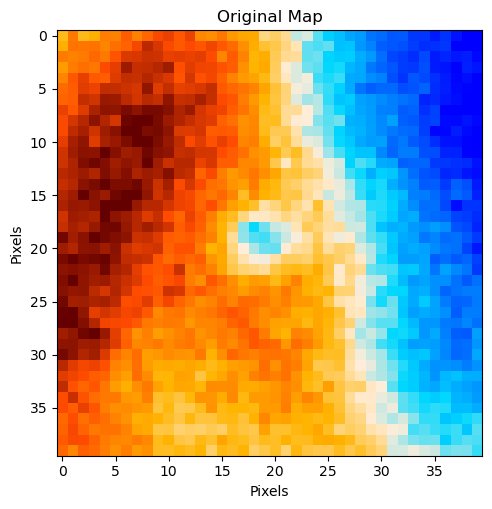

In [11]:
imap_box = galaxy_submap(file_path, 2.0418, 2.0204, 10)
#imap_box[0] extracts the temperature map!
plot1 = enplot.plot(imap_box[0], upgrade = 1, grid = False)

im1 = plt.imshow(np.array(plot1[0].img))
plt.tight_layout()
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.title("Original Map")

plt.show()

# Aperture Photometry

In [12]:
def get_tSZ_signal_aperture_photometry(dT_map, radmax_arcmin, pixel_scale, 
                                       fmax=np.sqrt(2)):
    """
    Retrieve aperture photometry of the tSZ signal
    
    Parameters:
    ----------
    dT_map: float array
        map in uK
    radmax_arcmin: float
        radius of the inner aperture in arcmin
    pixel_scale: float
        arcmin per pixel for the current settings
    fmax: float
        fmax * radmax_arcmin is the radius of the outer aperture in arcmin

    Returns:
    -------
    disk_mean: float
        average value within an annulus of inner radius r
    ring_mean: float
        average value within an annulus of outer radius sqrt(2)*r
    tSZ signal: float
        thermal SZ effect signal
    """

    radmax_pixels = radmax_arcmin / pixel_scale
    radius_out_pixels = radmax_pixels * fmax
    
    center = np.array(dT_map.shape) // 2
    x, y = np.indices(dT_map.shape)
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    
    #take the mean in inner disk
    disk_mean = dT_map[r < radmax_pixels].mean()
    
    #take mean of outer annulus
    ring_mean = dT_map[(r >= radmax_pixels) & (r < radius_out_pixels)].mean()
    
    #signal comes from the difference between the means
    tSZ = disk_mean - ring_mean
    return disk_mean, ring_mean, tSZ

In [13]:
ap_arcmin=2.1 #arcminutes for radius of inner circle
pix_scale = 0.5

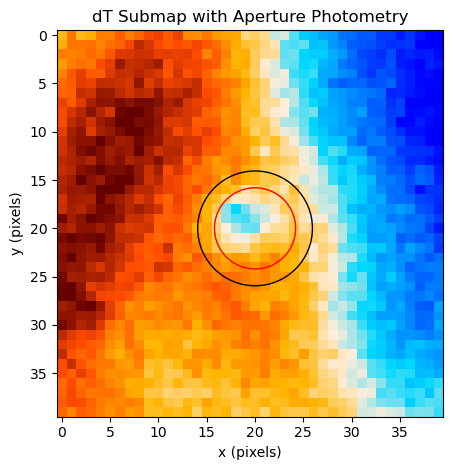

Average in inner radius: -72.51976
Average in outer radius: -33.421772
tSZ signal: -39.09799


In [14]:
# Convert to pixels
ap_pix = ap_arcmin / pix_scale
annulus_pix = ap_pix * np.sqrt(2)

# Center in pixel coordinates: (x, y)
ny, nx = imap_box[0].shape
center = (nx / 2, ny / 2)   # (20, 20) for 40×40

fig, ax = plt.subplots()

# Plot the map (origin='lower' to match usual enmap convention)
plot1 = enplot.plot(imap_box[0], upgrade = 1, grid = False)
im1 = plt.imshow(np.array(plot1[0].img))

# Add circles for aperture and annulus
disk_circle    = Circle(center, ap_pix,      color='red',   fill=False, linewidth=1)
annulus_circle = Circle(center, annulus_pix, color='black', fill=False, linewidth=1)

ax.add_patch(disk_circle)
ax.add_patch(annulus_circle)

ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
ax.set_title("dT Submap with Aperture Photometry")

plt.tight_layout()
plt.show()

#Calculate signal using aperature photometry
disk, ring, signal = get_tSZ_signal_aperture_photometry(imap_box[0], ap_arcmin, pix_scale)

print('Average in inner radius: '+str(disk))
print('Average in outer radius: '+str(ring))
print('tSZ signal: '+str(signal))

# Search Catalog for Mass and Redshift

Catalog for the DR5 Clusters is located here: https://lambda.gsfc.nasa.gov/product/act/actpol_dr5_szcluster_catalog_info.html 



In [26]:
!pip install colossus

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 1.9 MB/s eta 0:00:0000:0100:01


In [15]:
import pandas as pd
from astropy import constants as c
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from colossus.halo import mass_adv

In [16]:
#define cosmological values based on Battaglia2012

cosmo_battaglia = FlatLambdaCDM(
    H0 = 70 * u.km / u.s / u.Mpc,
    Om0 = 0.25
    # flat ΛCDM ⇒ ΩΛ = 1 − Ωm = 0.75
)

In [17]:
from colossus.cosmology import cosmology
#need to make colossus cosmology match Battaglia ones we defined

cosmo_params = {
    'flat': True,
    'H0': cosmo_battaglia.H0.value,  # 70.0 (km/s/Mpc)
    'Om0': cosmo_battaglia.Om0,      # 0.25
    'Ob0': 0.043,
    'sigma8': 0.8,  
    'ns': 0.96,
}

cosmology.addCosmology('battaglia', cosmo_params)
cosmology.setCosmology('battaglia')

In [18]:
catalog_path = "DR5_cluster-catalog_v1.1.fits"

In [19]:
hdul = fits.open(catalog_path)

data = hdul[1].data      # table is usually in extension 1
df = pd.DataFrame(np.array(data))  # convert to pandas DataFrame

hdul.close()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4195 entries, 0 to 4194
Data columns (total 51 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    4195 non-null   object 
 1   RADeg                   4195 non-null   float64
 2   decDeg                  4195 non-null   float64
 3   SNR                     4195 non-null   float64
 4   y_c                     4195 non-null   float64
 5   err_y_c                 4195 non-null   float64
 6   fixed_SNR               4195 non-null   float64
 7   fixed_y_c               4195 non-null   float64
 8   fixed_err_y_c           4195 non-null   float64
 9   template                4195 non-null   object 
 10  tileName                4195 non-null   object 
 11  redshift                4195 non-null   float64
 12  redshiftErr             4195 non-null   float64
 13  redshiftType            4195 non-null   object 
 14  redshiftSource          4195 non-null   

In [21]:
# Find nearest cluster
ra0, dec0 = 2.0418, 2.0204

#separation 
df['sep'] = np.sqrt((df['RADeg'] - ra0)**2 + (df['decDeg'] - dec0)**2)

match = df[df['sep'] < 0.05]   # within 3 arcmin
print(match)

                      name     RADeg    decDeg        SNR       y_c   err_y_c  \
50  b'ACT-CL J0008.1+0201'  2.045439  2.019734  15.930553  1.193494  0.074919   

    fixed_SNR  fixed_y_c  fixed_err_y_c              template  ... CAMIRA  \
50  15.724351   1.501979       0.095519  b'Arnaud_M8e14_z0p4'  ...     84   

    CAMIRA_N_mem  opt_RADeg opt_decDeg opt_positionSource  notes  \
50         70.37   2.043333   2.020083         b'Vis-BCG'    b''   

           knownLens  knownLensRefCode  warnings       sep  
50  b'000814+020120'          b'Jae20'       b''  0.003699  

[1 rows x 52 columns]


In [22]:
#convert M500c to M200c (as used in our model equations)
def M500c_to_M200c(M500c_cat, z):
    """
    Convert M500c (in Msun, not Msun/h) at redshift z
    to M200c (in Msun) using Colossus and a c(M,z) model.
    """
    h = cosmo_battaglia.h

    # Convert Msun → Msun/h
    M500c = M500c_cat * h

    # Do the conversion at fixed cosmology
    M200c, R200c, c200c = mass_adv.changeMassDefinitionCModel(
        M500c, z, '500c', '200c'
    )

    # Convert back to physical Msun and Mpc
    M200c_Msun = M200c / h             # Msun

    M200c_SM = M200c_Msun* 1e14

    return M200c_SM

In [23]:
#Extract Mass and Redshift:
M500c = float(match['M500c'].iloc[0])
z = float(match['redshift'].iloc[0])

M200c = M500c_to_M200c(M500c, z)

print(f"M200 = {M200c:.3e}")
print(f"Redshift = {z:.3}")

M200 = 5.264e+14
Redshift = 0.366


# Simulate Cluster Based on M200 and z
### Code for Pressure Profile Generating:
This code is based on DeepSZSim (https://github.com/deepskies/DeepSZSim) and "On the Cluster Physics of Sunyaev-Zel'dovich and X-Ray Surveys. II. Deconstructing the Thermal SZ Power Spectrum" (Battaglia 2012). More explanations of this code are found on my SZ_Simulation_Guide Notebook.

In [24]:
# constants
keVcm3_to_Jm3 = ((1 * u.keV / (u.cm**3.)).to(u.J / (u.m**3.))).value
Mpc_to_m = (1 * u.Mpc).to(u.m).value
Thomson_scale = (c.sigma_T/(c.m_e * c.c**2)).value

# conversion factor from Battaglia 2012
thermal_to_electron_pressure = 1 / 1.932 

In [25]:
def get_critical_density(redshift_z):
    """
    Calculates critical density beased on redshift value
    
    Parameters:
    -----------
    redshift
    
    Returns:
    ----------
    Critical_density as calculated in Battaglia 
    
    """
    
    # Critical density at z
    rho_cr = cosmo_battaglia.critical_density(redshift_z) # → kg/m^3 by default
    rho_cr_Msun_Mpc3 = rho_cr.to('Msun / Mpc3')
    
    return rho_cr_Msun_Mpc3
    

def get_R200(M200_SM, redshift_z):
    """
    
    Parameters:
    -----------
    M200_SM: float
         mass contained within R200, in units of solar masses
    redshift_z: float
         redshift of the cluster (unitless)
    
    Returns:
    --------
    R200_Mpc: instance
        radius of the cluster at 200 times the critical density of the universe in Mpc
    """

    rho_cr = get_critical_density(redshift_z)
    
    M200 = M200_SM * u.Msun                     # Msun
    R200_Mpc = (3 * M200 / (4 * np.pi * 200 * rho_cr))**(1/3)
    
    return R200_Mpc
    

def get_P200(M200_SM, redshift_z):
    """
    Calculates the P200 normalized thermal pressure of a cluster, as defined in Battaglia 2012.

    Parameters:
    -----------
    M200_SM: float
         mass contained within R200, in units of solar masses
    redshift_z: float
         redshift of the cluster (unitless)
    
   
    Returns:
    --------
    P200_kevcm3: instance
        thermal pressure of the shell defined by R200 in units of keV/cm**3
    """
    
    Omega_b = 0.043
    Omega_m = 0.25
    rho_cr = get_critical_density(redshift_z)
    
    GM200 = c.G * M200_SM * u.Msun * 200. * rho_cr #The Equation from above!! #R_Delta = 200
    
    R200_Mpc = get_R200(M200_SM, redshift_z)
    
    fbR200 = (Omega_b / Omega_m) / (2. * R200_Mpc)  # From Battaglia2012
   
    P200 = GM200 * fbR200
    P200_kevcm3 = P200.to(u.keV / u.cm**3.)  # Unit conversion to keV/cm^3
    
    return (P200_kevcm3)
    

def get_param(A0, alpha_m, alpha_z, M200_SM, redshift_z):
    
    """
    Calculates independent params using the formula from Battaglia 2012, Equation 11
    in order for use in the pressure profile defined in Equation 10

    Parameters:
    -----------
    A0: float
        normalization factor
    alpha_m: float
        power law index for the mass-dependent part of the function
    alpha_z: float
        power law index for the redshift dependent part
    M200_SM: float
        mass of the cluster at 200 times the critical density of the 
        universe in units of solar masses
    redshift_z: float
        redshift of the cluster

    Returns:
    --------
    A: float
        formula from Battaglia 2012, Eq 11
    """
    
    A = A0 * (M200_SM / 1e14)**alpha_m * (1. + redshift_z)**alpha_z
    
    return (A)
    

def get_P0(M200_SM, redshift_z):
    """
    Calculates P0, the normalization factor/amplitude, 
    from Battaglia 2012, using the values from Table 1

    Parameters:
    -----------
    M200_SM: float
        mass of the cluster at 200 times the critical density of the 
        universe, in units of solar masses
    redshift_z: float
        redshift of the cluster (unitless)

    Returns:
    -------
    P0: float
        normalization factor for the Battaglia 2012 profile

    """
    return get_param(18.1, 0.154, -0.758, M200_SM, redshift_z)
    


def get_xc(M200_SM, redshift_z):
    """
    Calculates xc (the core-scale factor) from Battaglia 2012 Table 1

    Parameters:
    -----------
    M200_SM: float
        mass of the cluster at 200 times the critical density of the 
        universe, in units of solar masses
    redshift_z: float
        redshift of the cluster (unitless)

    Returns:
    --------
    xc: float
        core-scale factor for the Battaglia 2012 profile

    """
    return get_param(0.497, -0.00865, 0.731, M200_SM, redshift_z)
    

def get_beta(M200_SM, redshift_z):
    
    """
    Calculates beta, the power law index, from Battaglia 2012 from Table 1.

    Parameters:
    ----------
    M200_SM: float
        mass of the cluster at 200 times the critical density of the 
        universe, in units of solar masses
    redshift_z: float
        redshift of the cluster (unitless)

    Returns:
    -------
    beta: float
        power law index for the Battaglia 2012 profile

    """
    return get_param(4.35, 0.0393, 0.415, M200_SM, redshift_z)


def get_Pfit(radius_mpc, M200_SM, redshift_z,
                    alpha = 1.0, gamma = -0.3):
    """
    Calculates the Pfit profile using the Battaglia profile, Battaglia 2012,
    Equation 10. It is unitless (normalized by P200)-- meaning it's really Pfit/P200.

    Parameters:
    -----------
    radius_mpc: float or float array
        radius for the pressure to be calculated at, in units of Mpc
    M200_SM: float
        mass contained within R200, in units of solar masses
    R_200_Mpc: float
        radius of the cluster at 200 times the critical density of the universe in Mpc
    redshift_z: float
        redshift of the cluster (unitless)
    alpha: float
        fixed by Battaglia et al 2012 to 1.0
    gamma: float
        fixed by Battaglia et al 2012 to -0.3

    Returns:
    --------
    Pfit: float or float array
        thermal pressure profile normalized by P200, which has units keV/cm**3
    """
    
    if isinstance(radius_mpc, Quantity):
        rvals = radius_mpc.to_value(u.Mpc)   # strip units → float
    else:
        rvals = radius_mpc                   # already floats
    
    #these vars are calculated using a function of mass and redshift
    P0 = get_P0(M200_SM, redshift_z)
    xc = get_xc(M200_SM, redshift_z)
    beta = get_beta(M200_SM, redshift_z)
    
    R200 = get_R200(M200_SM, redshift_z).to_value(u.Mpc)  # float
    P200 = get_P200(M200_SM, redshift_z)
    
    x =  rvals / R200
    
    Pfit = P0 * (x / xc)**gamma * (1 + (x / xc)**alpha)**(-beta)
    
    return (Pfit)


def arcmin_to_mpc(r_array, redshift_z):
    # attach unit
    r_array_arcmin = r_array * u.arcmin
    
    # convert to radians
    theta = r_array_arcmin.to(u.rad)
    
    # Make theta dimensionless (remove the 'rad' label)
    theta = theta.value * u.dimensionless_unscaled
    
    # get angular diameter distance (Quantity in Mpc)
    DA = cosmo_battaglia.angular_diameter_distance(redshift_z) 
    
    # multiply to get physical radius (Quantity in Mpc)
    r_array_mpc = (theta * DA).to(u.Mpc)
    
    return r_array_mpc

In [26]:
def Pe_to_y(radii_mpc, M200_SM, redshift_z, alpha = 1.0, gamma = -0.3):
    """
    Converts from an electron pressure profile to a compton-y profile;
    integrates over line of sight from -1 to 1 Mpc relative to center.

    Parameters:
    -----------
    radii_mpc: array
        array of radii corresponding to the profile in Mpc
    M200_SM: float
        mass contained within R200, in units of solar masses
    redshift_z: float
        redshift of the cluster (unitless)
    alpha: float
        variable fixed by Battaglia et al 2012 to 1.0
    gamma: float
        variable fixed by Battaglia et al 2012 to -0.3

    Returns:
    --------
    y_pro: array
        Compton-y profile corresponding to the radii.
        
    """
    
    #convert all Mpc to float values:
    R200 = get_R200(M200_SM, redshift_z).to_value(u.Mpc)  # float
    P200 = get_P200(M200_SM, redshift_z).value
    
    if isinstance(radii_mpc, Quantity):
        rvals = radii_mpc.to_value(u.Mpc)   # strip units → float
    else:
        rvals = radii_mpc                   # already floats
    
    pressure_integ = np.empty_like(rvals)
    rmax = rvals.max()
    
    for i, radius in enumerate(rvals):
        # Multiply profile by P200 specifically for Battaglia 2012 profile,
        # since it returns Pfit/P200 instead of Pfit
        rv = radius
        if (rv >= R200):
            pressure_integ[i] = 0
            
        else:
            l_mpc = np.linspace(0, np.sqrt(rmax**2. - rv**2.) + 1., 1000)  # Get line of sight axis
            th_pressure = get_Pfit(np.sqrt(l_mpc**2 + rv**2), M200_SM, redshift_z, alpha = alpha,
                                  gamma = gamma)
            
            integral = np.trapz(th_pressure, l_mpc)
            pressure_integ[i] = integral
    
    y_pro = pressure_integ * P200 * keVcm3_to_Jm3 * Thomson_scale * thermal_to_electron_pressure * 2 * Mpc_to_m
    
    return y_pro


def make_y_submap(M200_SM, redshift_z, image_size_pixels, pixel_size_arcmin, alpha = 1.0,
                   gamma = -0.3):
    """
    Converts from an electron pressure profile to a compton-y profile,
    integrates over line of sight from -1 to 1 Mpc relative to center.

    Parameters:
    -----------
    M200_SM: float
        mass contained in R200, in units of solar masses
    redshift_z: float
        redshift of the cluster (unitless)
    image_size_pixels: int
        size of final submap in number of pixels
    pixel_size_arcmin: float
        size of each pixel in arcmin
    alpha: float
        variable fixed by Battaglia et al 2012 to 1.0
    gamma: float
        variable fixed by Battaglia et al 2012 to -0.3

    Returns:
    -------
    y_map: array
        Compton-y submap with shape (image_size_pixels, image_size_pixels)
    """

    #Build a 1-D radius grid 
    #X runs from 0 to half the map in arcmin, sampled at pixel centers
    X = np.linspace(0, (image_size_pixels // 2) * pixel_size_arcmin, image_size_pixels//2 + 1)
    
    #convert to Mpc but remove the unit so X is a float
    X = arcmin_to_mpc(X, redshift_z).to_value(u.Mpc) 
    
    #Avoid singularity at center by setting minimum radius > 0
    min_radius = arcmin_to_mpc(pixel_size_arcmin*0.1, redshift_z).to_value(u.Mpc) 
    
    #Forms a grid of projected radii from the 1-D array X with the Square root part of the equation
    R = np.maximum(min_radius, np.sqrt(X[:, None]**2 + X[None, :]**2).flatten()) # [Mpc], 1D
    
    #evaluate compton-y for each neccesary radius 
    compton_y = Pe_to_y(R, M200_SM, redshift_z, alpha = alpha, gamma = gamma)  
    
    # Build empty map
    n = X.size
    y_map = np.zeros((2*n - 1, 2*n - 1))
    
    # Fill upper-right quadrant and mirror
    for i, x in enumerate(X):
        for j in range(i, len(X)):
            y = X[j]
            r_here = max(min_radius, np.sqrt(x**2 + y**2))
            idx = np.where(np.isclose(R, r_here, atol=1e-10, rtol=1e-10))[0][0]
            ijval = compton_y[idx]
            
            y_map[n + i - 1, n + j - 1] = ijval
            if j != i:
                y_map[n + j - 1, n + i - 1] = ijval
            
    # Mirror vertically
    for i in range(n):
        y_map[n - i - 1] = y_map[n + i - 1]

    # Mirror horizontally
    for j in range(n):
        y_map[:, n - j - 1] = y_map[:, n + j - 1]

    return y_map


In [28]:
def f_sz(freq_ghz, T_CMB_K):
    """
    leading order correction to blackbody from Compton scattering
    
    Parameters:
    ----------
    freq_ghz: float
        Observation frequency f, in units of GHz
    T_CMB_K: instance of temperature spectrum
        Temperature of CMB in K

    Returns:
    ------
    fsz: float
        radiation frequency
    """
    #Takes input in units of GHz
    f=freq_ghz*u.GHz 

    #Unit conversion
    f=f.to(1/u.s) 
    x = (c.h * f / c.k_B / T_CMB_K).value
    fsz = x * (np.exp(x) + 1) / (np.exp(x) - 1) - 4

    return fsz

In [34]:
from matplotlib.colors import LogNorm, SymLogNorm

def plot_graphs(image, title, xlabel, ylabel, cbarlabel, width,
                logNorm = False):
    """
    Plotting tool function for our 2D submaps and CMB maps 
    
    Parameters:
    -----------
    image: float array
        graph that is plotted
    title: str
        title of the graph
    xlabel: str
        label of the x-axis
    ylabel: str
        label of the y-axis
    cbarlabel: str
        label of the color bar
    width: int
        half rounded down of the width of output plot in pixels (eg, image size = 2*width+1)
    logNorm: bool
        if true, uses a logarithmic normalization for the plot (using SymLogNorm in case values are negative)
    

    Returns:
    -------
    none
    """
    
    if logNorm:
        if np.min(image)<0:
            imgflatabs = np.abs(image.flatten())
            im = plt.imshow(image, norm = SymLogNorm(linthresh =  np.min(imgflatabs[np.nonzero(imgflatabs)])))
        else:
            im = plt.imshow(image, norm=LogNorm())
    else:
        im = plt.imshow(image)
        
    cbar = plt.colorbar(im)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar.set_label(cbarlabel, rotation=270)

    return im, cbar

### Plot our simulated map:

In [29]:
#Recall M200c and z from the cluster:
print(f"M200 = {M200c:.3e}")
print(f"Redshift = {z:.3}")

M200 = 5.264e+14
Redshift = 0.366


y_max = 6.164797851694781e-05, y_min = 0.0


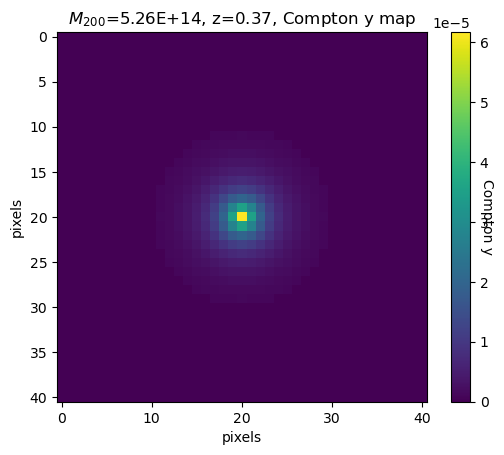

In [38]:
#### variables to set up the size of the map
N = 40  # pixel dimension is NxN
pix_size  = 0.5 # size of a pixel in arcminutes

y_map = make_y_submap(M200c, z, N, pix_size)

plot_graphs(y_map, '$M_{200}$='+f'{M200c:.2E}, z={z:0.2f}, Compton y map',
                          'pixels', 'pixels', 'Compton y', width=10)

print(f'y_max = {y_map.max()}, y_min = {y_map.min()}')

(<matplotlib.image.AxesImage at 0x7f1f112d3110>,
 <matplotlib.colorbar.Colorbar at 0x7f1f11301dd0>)

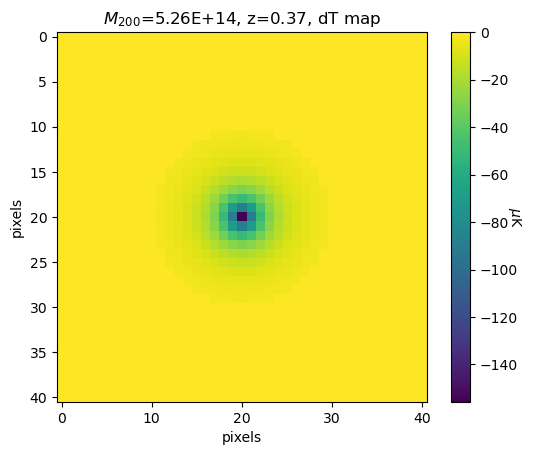

In [37]:
freq = 150 #observation frequency in GHz
Tcmb0 = 2.7 #picked average CMB temp in K

fSZ = f_sz(150, Tcmb0) #get f_SZ for particular frequency and temp

dT_map = (y_map * Tcmb0 * fSZ* u.K).to(u.uK).value
plot_graphs(dT_map, '$M_{200}$='+f'{M200c:.2E}, z={z:0.2f}, dT map',
                                'pixels', 'pixels', '$\mu$K', width=10)

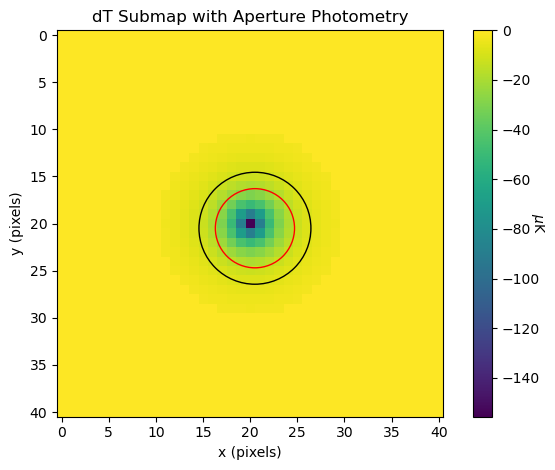

Average in inner radius: -39.050915413041054
Average in outer radius: -12.160949618209706
tSZ signal: -26.889965794831348


In [41]:
# Center in pixel coordinates: (x, y)
ny, nx = dT_map.shape
center = (nx / 2, ny / 2)   # (20, 20) for 40×40

fig, ax = plt.subplots()

# Plot the map (origin='lower' to match usual enmap convention)
plot_graphs(dT_map, '$M_{200}$='+f'{M200c:.2E}, z={z:0.2f}, dT map',
                                'pixels', 'pixels', '$\mu$K', width=10)

# Add circles for aperture and annulus
sim_disk_circle    = Circle(center, ap_pix,      color='red',   fill=False, linewidth=1)
sim_annulus_circle = Circle(center, annulus_pix, color='black', fill=False, linewidth=1)

ax.add_patch(sim_disk_circle)
ax.add_patch(sim_annulus_circle)

ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
ax.set_title("dT Submap with Aperture Photometry")

plt.tight_layout()
plt.show()

#Calculate signal using aperature photometry
sim_disk, sim_ring, sim_signal = get_tSZ_signal_aperture_photometry(dT_map, ap_arcmin, pix_scale)

print('Average in inner radius: '+str(sim_disk))
print('Average in outer radius: '+str(sim_ring))
print('tSZ signal: '+str(sim_signal))